# Population Structure Analysis Assignment

Load in the relevant packages, maybe even download some of them to your environment 

In [2]:
import allel
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Create softlinks to the data

In [ ]:
%%bash
ln -s ~/populationgenomics/data/assignment/relationships_w_pops_121708.txt .
ln -s ~/populationgenomics/data/assignment/hapmap.vcf .

For this assignment we will use Sci-kit allel to work with VCFs. 
Since it differs from the way we handled it during the course, Ill give you 
a little more of the code than I would normally do

We start by loading in the metadata to a neat Pandas dataframe

In [33]:
metadata = pd.read_csv('relationships_w_pops_121708.txt', sep = '\t')

In [34]:
metadata

,ID,dad,mom,sex,pheno,population
0,2469_NA20281,0,0,1,0,ASW
1,2357_NA19625,0,0,2,0,ASW
2,2367_NA19702,NA19700,NA19701,1,0,ASW
3,2367_NA19700,0,0,1,0,ASW
4,2367_NA19701,0,0,2,0,ASW
...,...,...,...,...,...,...
1297,Y116_NA19236,0,0,1,0,YRI
1298,Y116_NA19235,0,0,2,0,YRI
1299,Y120_NA19249,NA19248,NA19247,1,0,YRI
1300,Y120_NA19248,0,0,1,0,YRI


Lets load in the vcf information (this is done in memory, so if you are ever doing this outside this assignment, be mindfull about where you are on the cluster, as some vcf files can be rather huge)

In [7]:
callset = allel.read_vcf('hapmap.vcf')

If you want, you can look at the information and dataframe structure of this, to see if you can understand how to access it. For the PCA what we only really need is the genotypes, we can just save those directly to another variable.

In [10]:
genotypes = allel.GenotypeArray(callset['calldata/GT'])
genotypes

<GenotypeArray shape=(1803, 1184, 2) dtype=int8>
0/1 0/0 0/0 0/1 0/0 ... 0/0 0/0 0/0 0/0 0/1
0/0 1/1 1/1 0/0 0/1 ... 1/1 1/1 0/1 0/1 0/1
0/1 0/1 1/1 1/1 1/1 ... 1/1 0/0 1/1 0/1 0/0
...
0/0 0/1 0/0 0/1 0/1 ... 0/1 0/1 0/0 0/1 1/1
1/1 0/0 1/1 0/1 0/0 ... 0/1 0/0 1/1 0/0 1/1
1/1 1/1 1/1 0/0 0/1 ... 0/1 0/0 0/1 0/0 0/1

**Question 1: How many individuals and variants do we have?** 

Before we do the PCA, we will apply some filters:
* First, we will remove all variants that are fixed for the alternative allele 
* Second, we will remove all variants that is not biallilic

We are going to do this by creating a vector with the same length as the number of variants. If the variant pass the filters it will have True as the entry and FALSE if it fails.

In [12]:
allelcounts = genotypes.count_alleles()
pca_selection = (allelcounts.max_allele() == 1) & (allelcounts[:, :2].min(axis=1) > 2)
pca_selection

array([ True,  True,  True, ...,  True,  True,  True])

**Question 2: How many variants fail our filters** (hint: how many false is there in the 'pca_selection' vector)

In [17]:
gn = genotypes[pca_selection].to_n_alt()
gn

array([[1, 0, 0, ..., 0, 0, 1],
       [0, 2, 2, ..., 1, 1, 1],
       [1, 1, 2, ..., 2, 1, 0],
       ...,
       [0, 1, 0, ..., 0, 1, 2],
       [2, 0, 2, ..., 2, 0, 2],
       [2, 2, 2, ..., 1, 0, 1]], dtype=int8)

'gn' still holds only information of the genotype for each sample at each variant, but now it is encoded as the number of alternate alleles per call (i.e., 0 = hom ref, 1 = het, 2 = hom alt)

To run the following code to we need to give the total number of PCs. This can be estimated as the minimum between the total number of samples - 1 and the number of predictors.

In [25]:
n_pcs = min(gn.shape[0],gn.shape[1]-1)
coords, model = allel.pca(gn,n_pcs)

Let us look at the amount of variance explained by each of the PCs

Text(0, 0.5, 'Variance explained (%)')

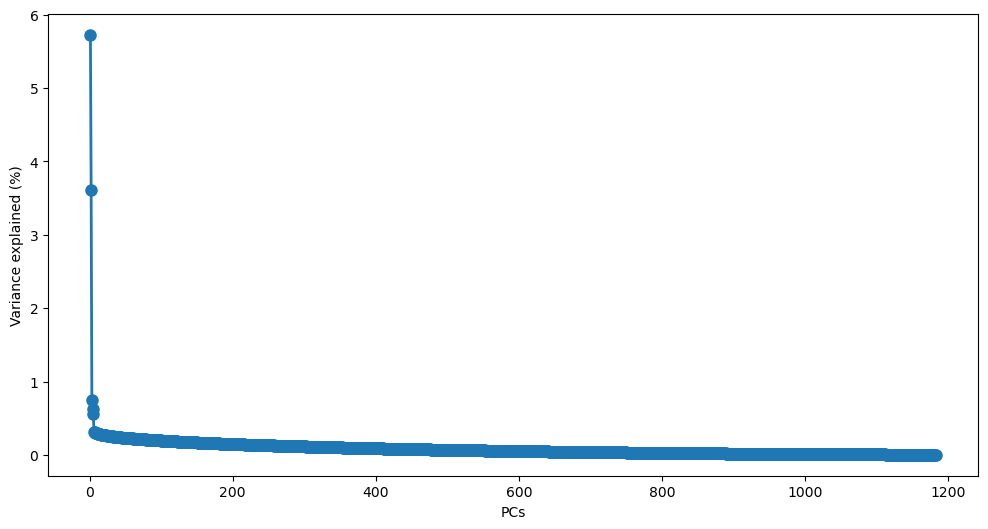

In [ ]:
#plot variance explained by each PC
y = model.explained_variance_ratio_*100
x = np.arange(1,len(y)+1)
plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('PCs')
plt.ylabel('Variance explained (%)')

Text(0, 0.5, 'Cumulative variance explained (%)')

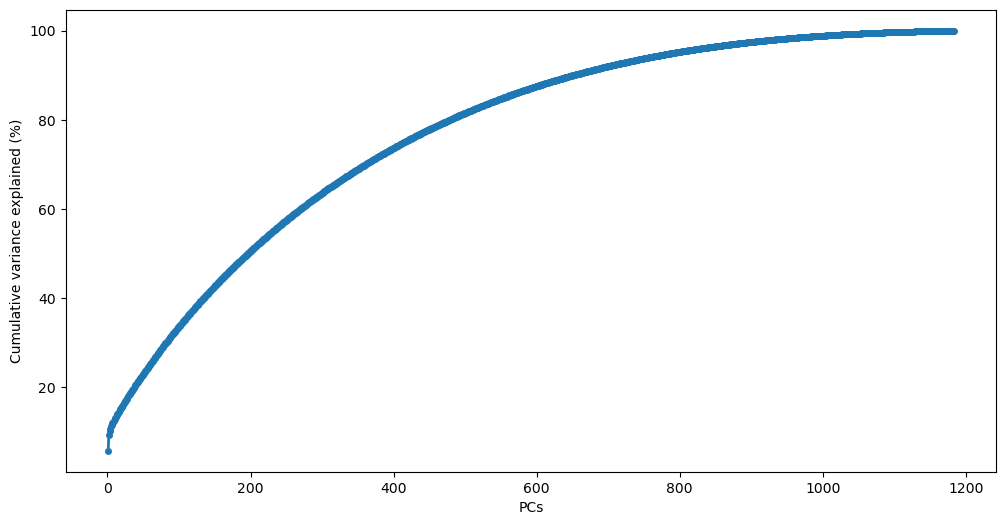

In [31]:
#plot the Cumulative Variance explained 
y = np.cumsum(model.explained_variance_ratio_*100)
x = np.arange(1,len(y)+1)
plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o', linestyle='-', linewidth=2, markersize=4)
plt.xlabel('PCs')
plt.ylabel('Cumulative variance explained (%)')

**Question 3: How much variance is roughly explained by the first two PCs?**

**Question 4: How does a PCA work? What is an eigenvector and an eigenvalue?**

**Question 5: How many PCs is needed to explain 50% of the variance?**

Before moving on and plotting the PCA, we need to match the sample names to the metadata

In [32]:
samples

,ID,dad,mom,sex,pheno,population
0,2469_NA20281,0,0,1,0,ASW
1,2357_NA19625,0,0,2,0,ASW
2,2367_NA19702,NA19700,NA19701,1,0,ASW
3,2367_NA19700,0,0,1,0,ASW
4,2367_NA19701,0,0,2,0,ASW
...,...,...,...,...,...,...
1297,Y116_NA19236,0,0,1,0,YRI
1298,Y116_NA19235,0,0,2,0,YRI
1299,Y120_NA19249,NA19248,NA19247,1,0,YRI
1300,Y120_NA19248,0,0,1,0,YRI


In [36]:
samples = callset['samples']
samples

array(['2427_NA19919', '2431_NA19916', '2424_NA19835', ...,
       'Y051_NA19207', 'Y042_NA19103', 'Y105_NA19099'], dtype=object)

In [49]:
populations = metadata['population'].unique()
sample_info = {row['ID']: row for _, row in metadata.iterrows()}
sample_info

{'2469_NA20281': ID            2469_NA20281
 dad                      0
 mom                      0
 sex                      1
 pheno                    0
 population             ASW
 Name: 0, dtype: object,
 '2357_NA19625': ID            2357_NA19625
 dad                      0
 mom                      0
 sex                      2
 pheno                    0
 population             ASW
 Name: 1, dtype: object,
 '2367_NA19702': ID            2367_NA19702
 dad                NA19700
 mom                NA19701
 sex                      1
 pheno                    0
 population             ASW
 Name: 2, dtype: object,
 '2367_NA19700': ID            2367_NA19700
 dad                      0
 mom                      0
 sex                      1
 pheno                    0
 population             ASW
 Name: 3, dtype: object,
 '2367_NA19701': ID            2367_NA19701
 dad                      0
 mom                      0
 sex                      2
 pheno                    0
 populat

Text(0.5, 1.0, 'PCA of Genetic Variation by Population')

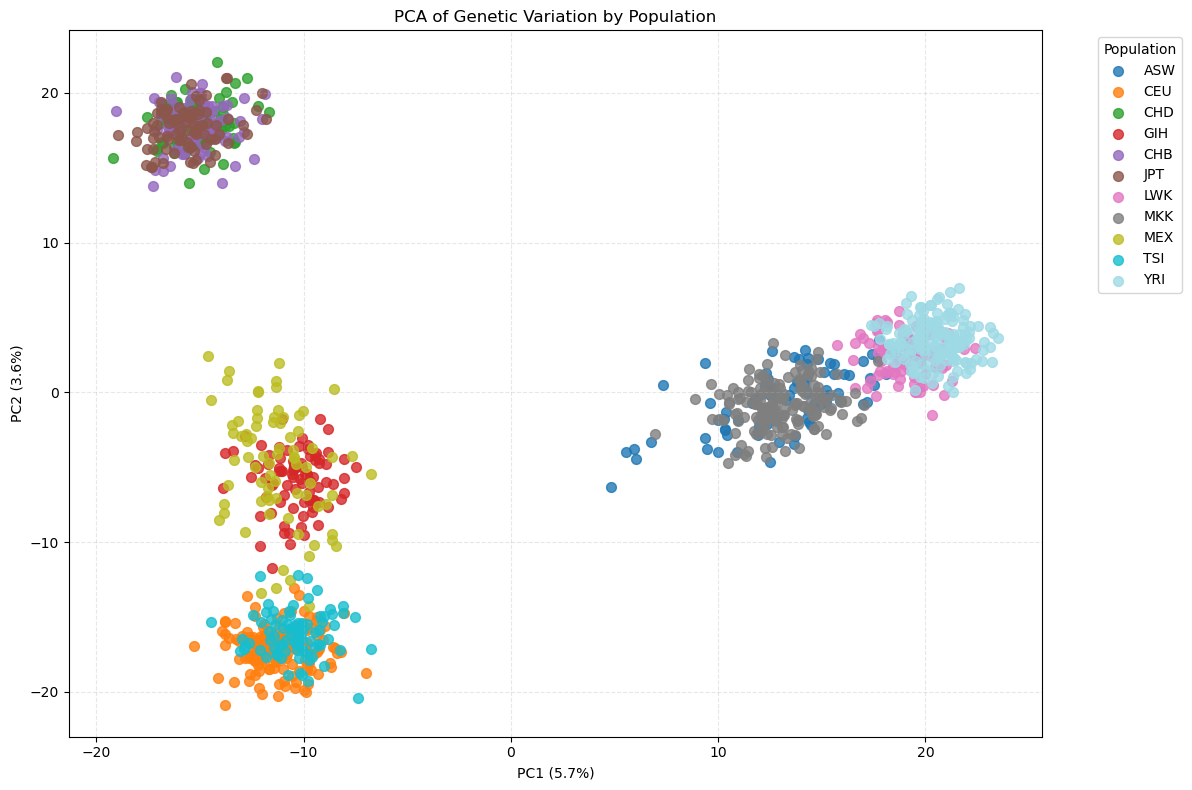

In [54]:
fig, ax = plt.subplots(figsize=(12, 8))

# Extract coordinates for the specified PCs
pc1 = coords[:, 0]
pc2 = coords[:, 1]
for i, pop in enumerate(populations):
    # Find samples belonging to this population
    pop_samples_idx = [idx for idx, sample in enumerate(samples) 
                        if sample in sample_info and sample_info[sample]['population'] == pop]
    
    if pop_samples_idx:
        # Plot this population
        ax.scatter(pc1[pop_samples_idx], pc2[pop_samples_idx], 
                    label=pop, color=cmap(i), s=50, alpha=0.8)

# Set labels with variance explained
ax.set_xlabel(f'PC{1} ({model.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC{2} ({model.explained_variance_ratio_[1]*100:.1f}%)')
    # Add title
ax.set_title('PCA of Genetic Variation by Population')

# Add legend
ax.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()

# Add title
ax.set_title('PCA of Genetic Variation by Population')

**Question 6: Explain the patterns you see. Which populations group together? Which groups are seperated?**

**Question 7: Try to plot PC2 and PC3. Do you see the same patterns? Describe them**

**Question 8: In your own words describe what which factors that drive population differentiation?**